In [7]:
import numpy as np
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [63]:

def mtanh(x, p):
    a = p[0]
    b = p[1]
    alpha = p[2]
    xsym = p[3]
    hwid = p[4]

    z = (xsym-x)/hwid

    y = a*((1 + alpha*z)*np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) + b
    return y


def mtanh_res(params, x_data, y_data, y_err):
    y_model = mtanh(x_data, params)
    res = (y_data - y_model)/y_err
    return res


def fit_mtanh(x_data, y_data, y_err=None):

    if y_err is None:
        y_err = np.ones(y_data.shape)
        y_err[np.abs(y_data)<1e-10] = 1e30

    p0 = np.array([1.0, 3.0, 0.01, 1.0, 0.01])
    pmin = np.array([0.1, 0.001, 0.0001, 0.85, 0.01])
    pmax = np.array([np.inf, np.inf, np.inf, 1.15, np.inf])

    kwargs = {'x_data': x_data,
              'y_data': y_data,
              'y_err': y_err}
    fit_out = least_squares(mtanh_res,
                            p0,
                            jac='2-point',
                            bounds=(pmin, pmax),
                            method='trf',
                            ftol=1e-08,
                            xtol=1e-08,
                            gtol=1e-08,
                            x_scale=1.0,
                            loss='linear',
                            f_scale=1.0,
                            diff_step=None,
                            tr_solver=None,
                            tr_options={},
                            jac_sparsity=None,
                            max_nfev=200,
                            verbose=0,
                            args=(),
                            kwargs=kwargs)
    return fit_out.x


def fit_profile(x_data, y_data, y_err=None):
    if y_err is None:
        y_err = np.ones(y_data.shape)
        y_err[np.abs(y_data)<1e-10] = 1e30

    p = fit_mtanh(x_data, y_data, y_err)
    x121 = np.linspace(0, 1.2, 121)
    y121 = mtanh(x121, p)
    x65 = np.linspace(0, 1, 65)
    y65 = interp1d(x121, y121, 'linear',
                   fill_value='extrapolate', assume_sorted=True)(x65)
    return y65


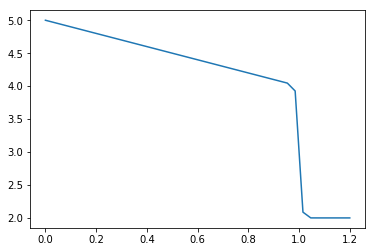

In [60]:
x = np.linspace(0,1.2,40)
p0 = np.array([1.0, 3.0, 0.01, 1.0, 0.01])
y = mtanh(x,p0)
plt.plot(x,y)


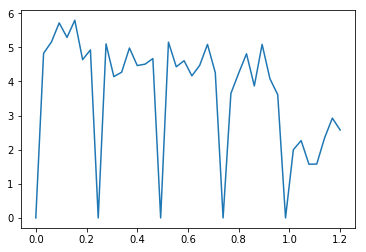

In [61]:
yn = y + np.random.normal(0,.5,y.shape)
yn[0:39:8] = 0
plt.plot(x,yn)

[1.e+30 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+30 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+30 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+30 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+30 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]


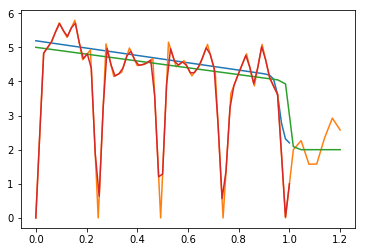

In [62]:


yp = fit_profile(x,yn)
x65 = np.linspace(0,1,65)
yinterp = interp1d(x,yn)(x65)
plt.plot(x65,yp,x,yn,x,y,x65,yinterp)

In [33]:
yp.shape

(65,)

(0, 6)

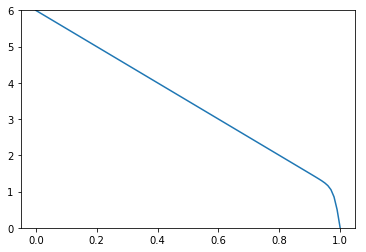

In [111]:
alpha = [1, 0.1, 0]
beta = [-1, 0, 0]
xsym = 1.0
hwid = 0.02
a = 1
b = 0
x = np.linspace(0,1,100)
z = (xsym-x)/hwid
y = a*((alpha[0] + alpha[1]*z + alpha[2]*z**2)*np.exp(z) + (beta[0] + beta[1]*z + beta[2]*z**2)*np.exp(-z)) / (np.exp(z) + np.exp(-z)) + b
plt.plot(x,y)
plt.ylim([0,6])

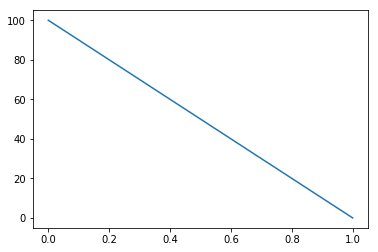

In [97]:
plt.plot(x,z)